In [98]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
import os
import csv
from PIL import Image

In [23]:


# Hyperparameters
batch_size = 256
learning_rate = 0.001
num_epochs = 20

# Load the MNIST dataset and split into training and testing sets
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split the dataset into 1000 training and 200 testing
# Define the sizes for train, validation, and test sets
train_size = 1000
val_size = len(mnist_dataset) - train_size - 200  # The rest goes to the validation set
test_size = 200

# Use random_split to create the datasets
train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# Create data loaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Initialize a list to store the new datasets with labels
train_dataset_with_counts = []
test_dataset_with_counts = []

# Apply the count_adjacent_ones function and create datasets with labels
def preprocessing(images):
    """
    Preprocess a batch of images to include adjacent ones counts.
    
    Args:
    images (torch.Tensor): A batch of binary images (0s and 1s).

    Returns:
    torch.Tensor: A tensor containing the adjacent ones counts for each image in the batch.
    """
    counts_batch = []
    for image in images:
        # Convert images to binary images by thresholding (you might need to adjust the threshold)
        binary_image = (image > 0.5).float()

        # Get the counts of adjacent ones
        counts = count_adjacent_ones(binary_image)
        counts_batch.append(torch.from_numpy(counts))  # Convert to a PyTorch Tensor

    counts_batch = torch.stack(counts_batch)  # Convert to a tensor
    return counts_batch


# Initialize a list to store the new datasets with labels
# Initialize lists to store images, counts, and labels
train_images = []
train_counts = []
train_labels = []

test_images = []
test_counts = []
test_labels = []


# Apply the preprocessing function to create datasets with labels
for dataset, images_list, counts_list, labels_list in [
    (train_dataloader, train_images, train_counts, train_labels),
    (test_dataloader, test_images, test_counts, test_labels)
]:
    for images, labels in dataset:
        # Preprocess the images to get counts
        counts_batch = preprocessing(images)

        # Append images, counts, and labels to the respective lists
        images_list.extend(images)
        counts_list.extend(counts_batch)
        labels_list.extend(labels)


In [40]:
def gen_pins(image, n):
    """
    Generate a list of n unique random (x, y) coordinate pins within the dimensions of the image.

    Args:
    image (numpy.ndarray): Input image.
    n (int): Number of unique random pins to generate.

    Returns:
    list of tuples: List of (x, y) coordinate tuples representing unique random pins.
    """
    h, w = image.shape  # Get the dimensions of the image
    total_pixels = h * w

    # Ensure that n is not greater than the total number of pixels
    n = min(n, total_pixels)

    # Generate a list of all possible (x, y) coordinates
    all_possible_pins = [(x, y) for x in range(h) for y in range(w)]

    # Shuffle the list to randomize the order
    random.shuffle(all_possible_pins)

    # Select the first n coordinates to ensure uniqueness
    unique_pins = all_possible_pins[:n]

    return unique_pins



In [72]:
# # Load a binary image (0s and 1s)
# binary_image = np.array([[0, 1, 0, 0, 1],
#                   [0, 1, 1, 0, 0],
#                   [0, 0, 1, 0, 1],
#                   [1, 0, 1, 0, 1],
#                   [1, 1, 1, 0, 0]])


def count_within_radius(image, center_x, center_y, radius):
    """
    Count the number of pixels with value 1 within a specified radius around a given pixel.

    Args:
    image (numpy.ndarray): Binary image where 1 represents the object and 0 the background.
    center_x (int): X-coordinate of the center pixel.
    center_y (int): Y-coordinate of the center pixel.
    radius (int): The radius within which to count adjacent ones.

    Returns:
    int: The count of adjacent ones within the specified radius around the center pixel.
    """
    h, w = image.shape
    count = 0

    for x in range(center_x - radius, center_x + radius + 1):
        for y in range(center_y - radius, center_y + radius + 1):
            if 0 <= x < h and 0 <= y < w:
                if image[x, y] > 0:
                    count += 1

    return count

def count_all(binary_image, radius=1):
    # Initialize an empty count image with the same shape as the binary image
    count_image = np.zeros_like(binary_image, dtype=np.uint8)
    # Iterate through each pixel in the binary image and apply the count function
    for x in range(binary_image.shape[0]):
        for y in range(binary_image.shape[1]):
            count = count_ones_within_radius(binary_image, x, y, radius)
            count_image[x, y] = count
    return count_image


def count_pins(binary_image, pins, radius):
    """
    Count the number of adjacent ones within a specified radius around a selection of points.

    Args:
    binary_image (numpy.ndarray): Binary image where 1 represents the object and 0 the background.
    pins (list of tuples): List of (x, y) coordinate tuples specifying the points of interest.
    radius (int): The radius within which to count adjacent ones.

    Returns:
    numpy.ndarray: An image with counts of adjacent ones within the specified radius around the points.
    """
    # Initialize an empty count image with the same shape as the binary image
    count_image = np.zeros_like(binary_image, dtype=np.uint8)

    for pin in pins:
        x, y = pin
        count = count_within_radius(binary_image, x, y, radius)
        count_image[x, y] = count

    return count_image


In [78]:
def PinMNIST(n, n_pin_max, r, fixed_pins=True):
    """
    Generate PinMNIST dataset by selecting n unique samples from the original MNIST and adding pins.

    Args:
    n (int): Number of unique samples to select from the original MNIST.
    n_pin_max (int): Maximum number of pins to generate for each sample.
    r (int): Radius for counting adjacent ones around each pin.
    fixed_pins (bool): If True, generates a fixed number of pins (n_pin_max) for all samples. If False, generates a random number of pins for each sample.

    Returns:
    images (list): List of binary images.
    pins (list): List of lists of (x, y) coordinate tuples.
    count_images (list): List of count images where counts are the counted values at the pin locations.
    """
    # Load the original MNIST dataset
    original_mnist = MNIST(root='./data', train=True, download=True)

    # Shuffle the original MNIST dataset
    random.shuffle(original_mnist.data)

    # Initialize lists to store images, pins, and count images
    images = []
    pins = []
    count_images = []

    for i in range(n):
        # Get the binary image from the shuffled MNIST dataset
        mnist_image = original_mnist.data[i] / 255.0  # Normalize to [0, 1]

        # Determine the number of pins to generate
        if fixed_pins:
            n_pins = n_pin_max
        else:
            n_pins = random.randint(1, n_pin_max)

        # Generate random pins for the binary image
        pin_locations = gen_pins(mnist_image, n_pins)

        # Count the adjacent ones for the pins using the count_pins function
        count_image = count_pins(mnist_image.numpy(), pin_locations, r)

        images.append(mnist_image)
        pins.append(pin_locations)
        count_images.append(count_image)

    return images, pins, count_images

n=1000
n_pin_max = 500
fixed_pins = True
r = 3

images, pins, count_images = PinMNIST(n, n_pin_max, r)

In [79]:
def visualize_pins(image, pins, color_map='viridis'):
    """
    Visualize pin locations with color mapping for the values and displaying the image using plt.imshow.

    Args:
    image (numpy.ndarray): Binary image.
    pins (list of tuples): List of (x, y) coordinate tuples representing pin locations.
    color_map (str): The colormap to use for displaying the values.

    """
    # Create a copy of the image to avoid modifying the original
    image_with_pins = np.zeros_like(image.detach().cpu().numpy().copy())

    # Set the locations with pins to 1
    for pin in pins:
        x, y = pin
        image_with_pins[x, y] = 1
        
    return image_with_pins
    # # Display the image with pins and values using plt.imshow
    # plt.imshow(image_with_pins, cmap=color_map)
    # plt.colorbar()
    # plt.axis('off')  # Hide axes
    # plt.show()


# Assuming 'image' is the binary image and 'pins' is the list of (x, y) coordinate tuples
# visualize_pins(images[0], pins[0], color_map='viridis')

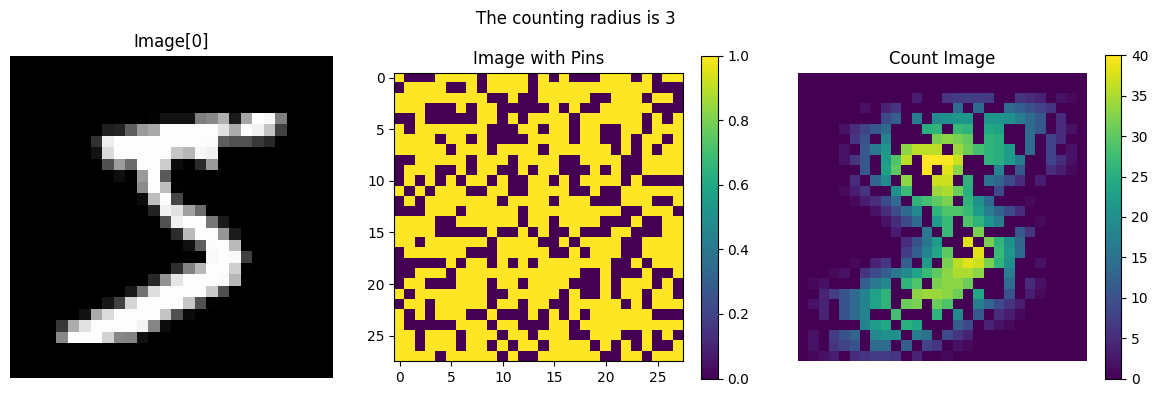

In [85]:

# Create a subplot with three columns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Display the original binary image (image[0]) in the first column
axes[0].imshow(images[0], cmap='gray')
axes[0].set_title("Image[0]")
axes[0].axis('off')

# # Display the image with pins and color mapping in the second column
axes[1].imshow(visualize_pins(images[0], pins[0]), cmap='viridis')
cbar1 = plt.colorbar(axes[1].images[0], ax=axes[1])  # Add colorbar to axes[1]
axes[1].set_title("Image with Pins")

# Display the count image (count_images[0]) in the third column
im = axes[2].imshow(count_images[0], cmap='viridis')
cbar2 = plt.colorbar(im, ax=axes[2])  # Add colorbar to axes[2]
axes[2].set_title("Count Image")
axes[2].axis('off')

plt.suptitle("The counting radius is 3")
plt.tight_layout()
plt.show()


In [100]:
def save_data(images, pins, count_images, output_directory, image_size=(256, 256)):
    """
    Save data of images, pins, and count images to CSV and save images in the specified output directory and subdirectories.

    Args:
    images (list): List of binary images.
    pins (list): List of lists of (x, y) coordinate tuples representing pin locations.
    count_images (list): List of count images where counts are the counted values at the pin locations.
    output_directory (str): The directory where data, images, and count images will be saved.
    image_size (tuple): The size (width, height) of the images to be saved.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Define subdirectories for images and count images
    images_directory = os.path.join(output_directory, 'images')
    count_images_directory = os.path.join(output_directory, 'count_images')

    # Create subdirectories for images and count images
    os.makedirs(images_directory, exist_ok=True)
    os.makedirs(count_images_directory, exist_ok=True)

    # Save images as "0.png", "1.png", etc., and dump data to CSV
    with open(os.path.join(output_directory, 'data.csv'), 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Write the header row
        csv_writer.writerow(['image', 'pins', 'counted_images'])

        for i, (image, image_pins, count_image) in enumerate(zip(images, pins, count_images)):
            # Save the image as "i.png" in the images subdirectory with the specified size
            image_filename = os.path.join(images_directory, f"{i}.png")
            image = image.detach().cpu().numpy()
            im = Image.fromarray((image * 255).astype('uint8'))
            im = im.resize(image_size, Image.ANTIALIAS)
            im.save(image_filename)

            # Save the count image as "count_i.png" in the count_images subdirectory with the specified size
            count_image_filename = os.path.join(count_images_directory, f"count_{i}.png")
            count_im = Image.fromarray((count_image * 255).astype('uint8'))
            count_im = count_im.resize(image_size, Image.ANTIALIAS)
            count_im.save(count_image_filename)

            # Write data to CSV
            csv_writer.writerow([f"{i}.png", str(image_pins), f"count_{i}.png"])

    print("Data and images have been saved to the CSV and image files.")
    
output_directory = f'./data/MNIST_{n}images_28by28pixels_upto{n_pin_max}pins_fixedpins{fixed_pins}_radius{r}/'
os.makedirs(output_directory, exist_ok=True)  
save_data(images, pins, count_images, output_directory)

/tmp/ipykernel_101860/700842531.py:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(image_size, Image.ANTIALIAS)
/tmp/ipykernel_101860/700842531.py:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  count_im = count_im.resize(image_size, Image.ANTIALIAS)


Data and images have been saved to the CSV and image files.
